# Traffic Sign Detection Solution
Source: Tobias Augspurger for Udacity ND

## Load Data and your Dependencies

Load the German Traffic Sign Dataset into train, valid and test data.

In [1]:
import cv2
import numpy as np
import pandas as pd
import random
import pickle
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten

training_file = "imagesDL/train.p"
validation_file="imagesDL/valid.p"
testing_file = "imagesDL/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

import signal
import sys
def signal_handler(signal, frame):
        print('You pressed Ctrl+C!')
        sys.exit(0)

# Show Shape and Dimensions

X_train shape: (34799, 32, 32, 3)
y_train shape: (34799,)
X_test shape: (12630, 32, 32, 3)
y_test shape: (12630,)
 Traffic Sign Image Shape: (32, 32, 3)
Number Training Images (32, 32, 3)
Number of Validation Images (32, 32, 3)
Number of Classes 43


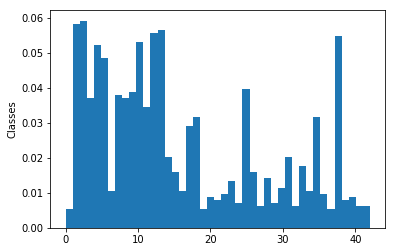

In [2]:
num_c = len(np.unique(y_train))
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print(" Traffic Sign Image Shape: {}".format(X_train[0].shape))
print("Number Training Images", X_train[0].shape)
print("Number of Validation Images", X_validation[0].shape)
print("Number of Classes",num_c)
# Plot The Probability of the Classes
plt.hist(y_train,bins = num_c, normed = True)
plt.ylabel('Probability')
plt.ylabel('Classes')

## Visualize Data

Show 20 Random Pictures from the Dataset

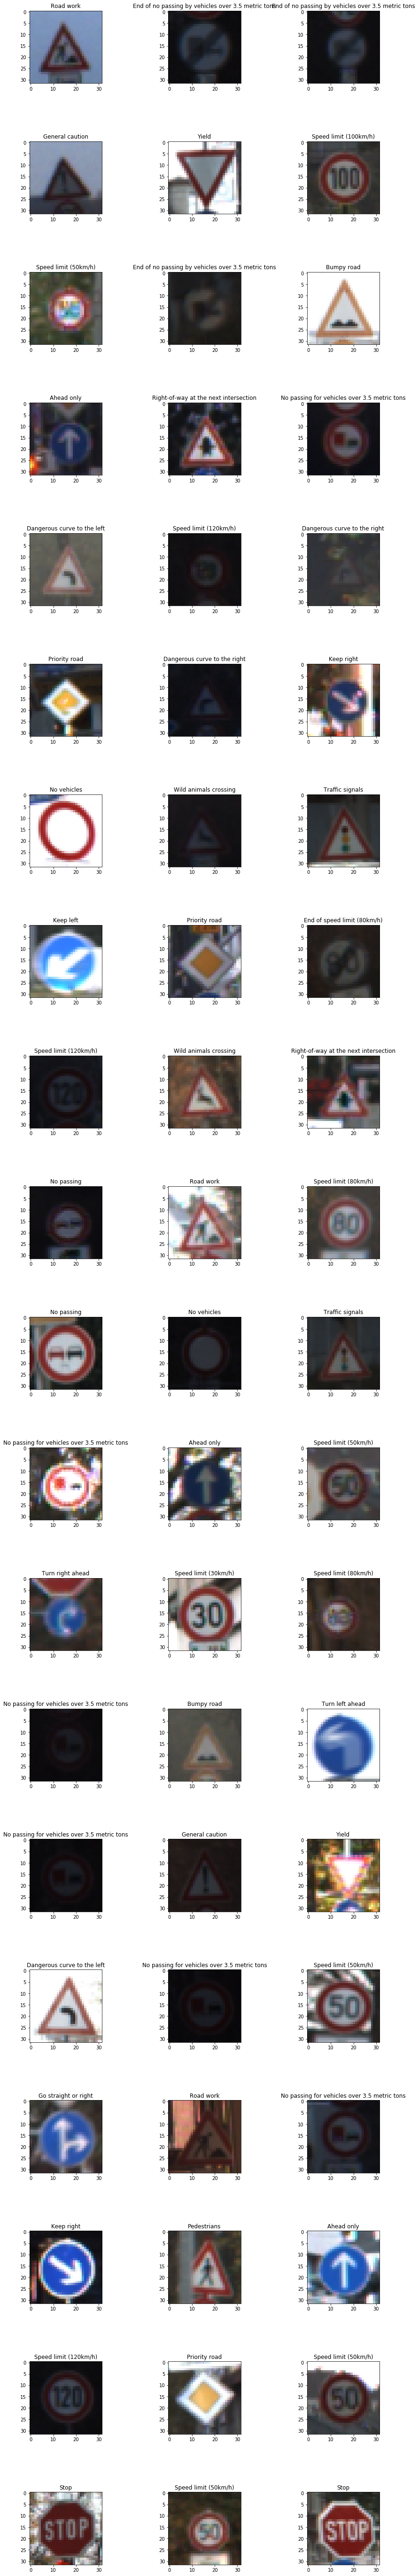

In [3]:
classes = pd.read_csv("signnames.csv")
classes.set_index("ClassId")
plt.figure(figsize=(15, 100))
pic_dis = 60
pic_p_raw = 3

for i in range(0,pic_dis):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    plt.subplot(pic_dis/pic_p_raw ,3,1+i)
    plt.imshow(image, cmap="gray")
    plt.subplots_adjust(hspace=0.8)
    plt.title(classes.at[y_train[index],'SignName'])

# Preprocess Data

Shuffle the training data and preprocess the features by normalization and reduction of the data to a single channel.

In [4]:
def preprocessing_feature(X):
    # Since Traffic Sign have colour Space for humans use that:
    # https://samarthbhargav.wordpress.com/2014/05/05/image-processing-with-python-rgb-to-grayscale-conversion/
    X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]
    
    # Magic Feature Scaling with the a 8 Bit Pixel value
    # https://en.wikipedia.org/wiki/Feature_scaling
    # Rescaling
    X = (X / 255.).astype(np.float32)
    
    #Single Greyscale Channel
    X = X.reshape(X.shape + (1,)) 
    return X

# Shuffle the Trainingsdata
X_train, y_train = shuffle(X_train, y_train)
X_test = preprocessing_feature(X_test)
X_train = preprocessing_feature(X_train)
X_train, y_train = shuffle(X_train, y_train)
# Generate a Random Split of the Traning Data for Validation
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.20)

## Setup Your Hyperparamter
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

In [5]:
EPOCHS = 2
BATCH_SIZE = 128
rate = 0.001
# Since the Model is not to big use smaller dropout
dropc1 = 0.7
dropc2 = 0.8
dropoutfc1 = tf.placeholder(tf.float32)
dropoutfc2 = tf.placeholder(tf.float32)
# Dropout value indicates propapility to keep value
# Dropout is used the reduce the overfitting of the data by switching connections off an on.
# This should increase the generalization

# Define the Architecture of the DNN Model
After playing with lots of different types I came back to the original LenNet and exdendet it.

In [6]:
def lendeepnn_model(x):
    # 2xConv->Concatenate->Conv->2xPooling->2xConv->Concatente->Pooling->Flatten->FullyConnected_with_dropout

    mu = 0
    sigma = 0.1
    # Kernel Size 5*5
    #Layer 1a: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1a_w = tf.Variable(tf.truncated_normal(shape=(5,5,1,6), mean = mu, stddev = sigma))
    conv1a_b = tf.Variable(tf.zeros(6))
    #Y = x*w+b
    conv1a = tf.nn.conv2d(x,conv1a_w,strides= [1,1,1,1],padding = 'VALID') + conv1a_b
    
    #ReLU Activation.
    conv1a = tf.nn.relu(conv1a)
    
    # Kernel Size 3*3
    #Layer 1b: Convolutional. Input = 32x32x1. Output = 30x30x6.
    conv1b_w = tf.Variable(tf.truncated_normal(shape=(3,3,1,6), mean = mu, stddev = sigma))
    conv1b_b = tf.Variable(tf.zeros(6))
    conv1b = tf.nn.conv2d(x,conv1b_w,strides= [1,1,1,1],padding = 'VALID') + conv1b_b
    
    #Layer 1c: Convolution. conv1b as Input = 30x30x6, Output = 28x28x6
    conv1c_w = tf.Variable(tf.truncated_normal(shape=(3,3,6,6), mean = mu, stddev = sigma))
    conv1c_b = tf.Variable(tf.zeros(6))
    conv1c = tf.nn.conv2d(conv1b, conv1c_w,strides= [1,1,1,1],padding = 'VALID') + conv1c_b
    
    #Concatenate Tensorflow operation
    conv1 = tf.nn.relu(tf.concat([conv1a,conv1c],axis =3))

    #Toggled shape Output Size to 24
    #Layer 2: Convolution. conv1 as Input = 28x28x12, Output = 28x28x6
    conv2_w = tf.Variable(tf.truncated_normal(shape=(1,1,12,24), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(24))
    conv2 = tf.nn.conv2d(conv1, conv2_w,strides= [1,1,1,1],padding = 'VALID') + conv2_b
    
    #Pooling. Input = 28x28x6. Output = 14x14x6.
    conv2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')   
    
    #Pooling for conv1a Input = 28x28x6. Output = 14x14x6
    conv1_3 = tf.nn.max_pool(conv1a, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')   
    
    #Layer 3a: Convolutional. Input: 14x14x6. Output = 10x10x16.
    conv3a_w = tf.Variable(tf.truncated_normal(shape = (5,5,24,16),mean= mu, stddev = sigma))
    conv3a_b= tf.Variable(tf.zeros(16))
    conv3a = tf.nn.conv2d(conv2,conv3a_w,strides=[1,1,1,1],padding = 'VALID')+conv3a_b
    
    #Layer 3b: Convolutional. conv1_3 Input: 14x14x6. Output = 10x10x16.
    conv3b_w = tf.Variable(tf.truncated_normal(shape = (5,5,6,16),mean= mu, stddev = sigma))
    conv3b_b= tf.Variable(tf.zeros(16))
    conv3b = tf.nn.conv2d(conv1_3,conv3b_w,strides=[1,1,1,1],padding = 'VALID')+conv3b_b
    
    
    #Concatenate conv3a and conv3b convolutions and use relu on it
    conv3 = tf.nn.relu(tf.concat([conv3a,conv3b],axis =3))
    
    
    
    conv4_w = tf.Variable(tf.truncated_normal(shape=(1,1,32,16), mean = mu, stddev = sigma))
    conv4_b = tf.Variable(tf.zeros(16))
    conv4 = tf.nn.conv2d(conv3, conv4_w,strides= [1,1,1,1],padding = 'VALID') + conv4_b
    
    #ReLU Activation.
    conv4= tf.nn.relu(conv4)
    
    #Pooling. Input = 10x10x16. Output = 5x5x16.
    conv4 = tf.nn.max_pool(conv4,ksize=[1,2,2,1],strides = [1,2,2,1],padding = 'VALID')
    
    #Flatten. Input = 5x5x16. Output = 400.
    conv4 = flatten(conv4)
    
    
    #Layer 5: Fully Connected. Input = 400. Output = 120.
    fc1_w = tf.Variable(tf.truncated_normal((400,120), mean=mu,stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(conv4,fc1_w)+fc1_b
    
    #ReLU Activation.
    fc1 = tf.nn.relu(fc1)
    
    #Dropout
    fc1 = tf.nn.dropout(fc1,dropoutfc1)
    
    #Layer 6: Fully Connected. Input = 120. Output = 84.
    fc2_w = tf.Variable(tf.truncated_normal((120,84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_w)+fc2_b
    
    #ReLU Activation.
    fc2 = tf.nn.relu(fc2)
    
    #Dropout
    fc2 = tf.nn.dropout(fc2,dropoutfc2)
    
    #Layer 5: Fully Connected. Input = 84. Output = 43
    logits_w= tf.Variable(tf.truncated_normal((84,43), mean= mu, stddev= sigma))
    logits_b= tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2,logits_w)+logits_b
    
    
    return logits


## Features and Labels
Use one hot encodding for your labeling data.

In [7]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
# Number of classes
one_hot_y = tf.one_hot(y, 43)

## Training Pipeline
Define the Training pileline with a reduction of the mean cross entropy by the Adam optimizer

In [8]:
logits = lendeepnn_model(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
# Dynamic adjustment of the learning rate
# https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [9]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, dropc1 = 1,dropc2 = 1):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={dropoutfc1: dropc1,dropoutfc2: dropc2, x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Dont forget to turn on dropout 

Training...

EPOCH 1 ...
Validation Accuracy = 0.367

EPOCH 2 ...
Validation Accuracy = 0.701

Model saved


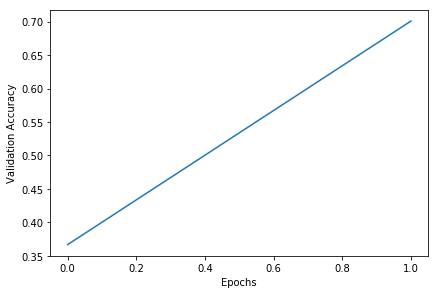

In [10]:
validation_progress = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={dropoutfc1: dropc1,dropoutfc2: dropc2, x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation, dropc1, dropc2)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        validation_progress.append(validation_accuracy)
        
    saver.save(sess, './ly0nnet')
    print("Model saved")
    plt.plot(validation_progress)
    plt.tight_layout()
    plt.ylabel('Validation Accuracy')
    plt.xlabel('Epochs')

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

In [11]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test,1,1)
    print("Validation Accuracy = {:.3f}".format(validation_accuracy))
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Validation Accuracy = 0.725
Test Accuracy = 0.763


## Load Wild Images
Load New Images not connected to this dataset


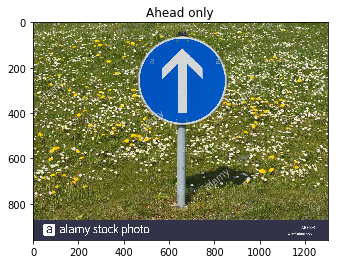

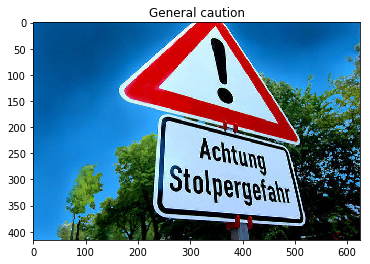

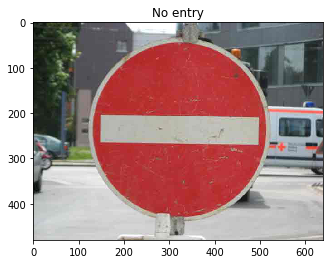

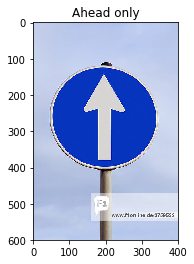

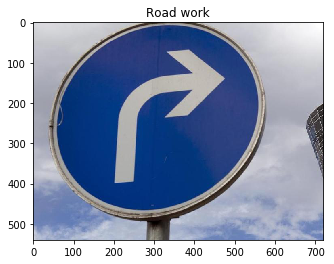

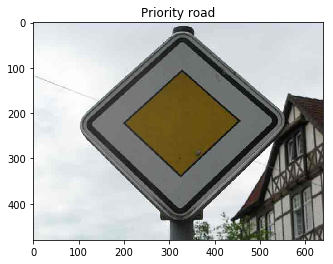

Test Accuracy = 0.333


In [13]:
images_w = []
labels_w = []
images_w_org = []
import glob
from PIL import Image
for line in open('random_valid/data','r'):
    fname, label = line.strip().split(' ')
    label = int(label)
    fname = 'random_valid/'+fname
    img = cv2.imread(fname)
    # Convert the Image to BW
    grey = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # OpenCV is Saving the RGB in BGR
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.title(classes.at[label,'SignName'])
    plt.show()
    # Resize
    img_sized = cv2.resize(grey,(32,32))
    # Normalize in [0] to [1]
    img_sized = (img_sized / 255.0)
    # Add the Last Dimension to get (?,32,32,1) for the tf placeholder
    img_sized.shape = img_sized.shape + (1,)
    images_w.append(img_sized)
    labels_w.append(label)
    images_w_org.append(img)
    

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(images_w, labels_w,1,1)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

# Check the Top5 Softmax probabilities


In [19]:
k = 5
smax_logits = tf.nn.softmax(logits)
top_n = tf.nn.top_k(smax_logits,k=k)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    wild_smax_logits = sess.run(smax_logits, feed_dict={dropoutfc1: dropc1,dropoutfc2: dropc2,x: images_w})
    top_k = sess.run(top_n, feed_dict={dropoutfc1: dropc1,dropoutfc2: dropc2,x: images_w})
print(top_k)

TopKV2(values=array([[  3.97809178e-01,   1.45613477e-01,   1.44208565e-01,
          8.54186341e-02,   4.36339341e-02],
       [  8.58730733e-01,   4.73599322e-02,   3.12836803e-02,
          1.42688733e-02,   1.02869067e-02],
       [  9.94702518e-01,   4.09829849e-03,   1.19120197e-03,
          4.20874903e-06,   1.65382232e-06],
       [  3.60653490e-01,   3.09918463e-01,   2.87102491e-01,
          1.80456359e-02,   5.85152209e-03],
       [  2.79552579e-01,   2.14437932e-01,   1.36971697e-01,
          9.80072767e-02,   7.45943114e-02],
       [  9.59548056e-01,   1.21733267e-02,   8.12526327e-03,
          5.62007353e-03,   3.83280008e-03]], dtype=float32), indices=array([[22, 17, 39, 12, 14],
       [22,  0, 36, 40, 17],
       [17, 33,  9, 12, 37],
       [ 7,  3,  5,  8, 35],
       [32, 12,  1, 42, 40],
       [12, 18, 26, 40,  1]], dtype=int32))


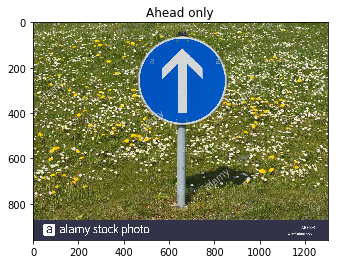

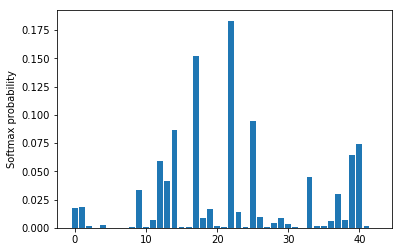

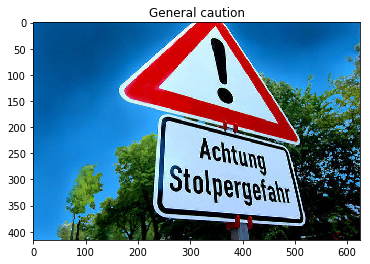

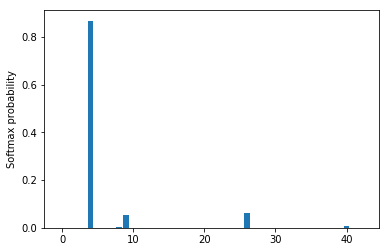

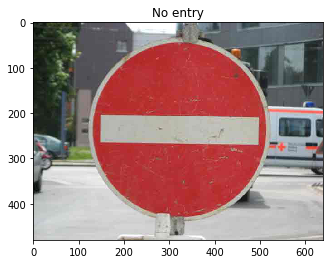

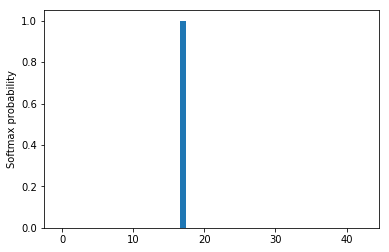

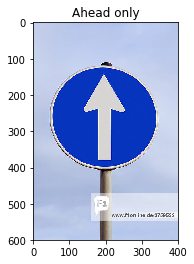

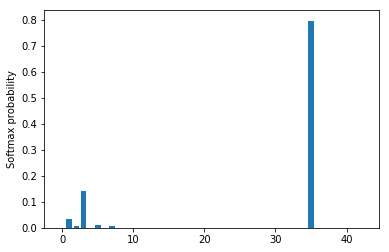

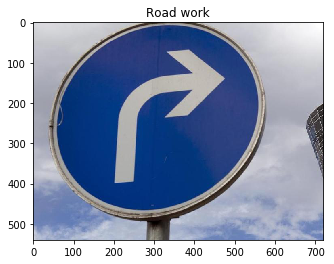

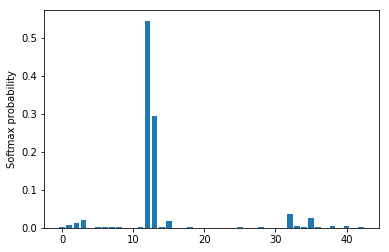

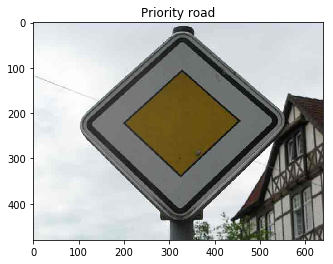

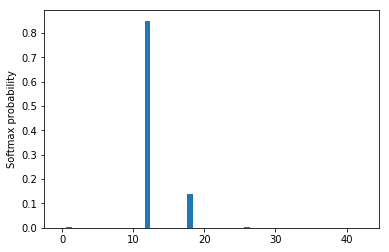

In [27]:
for i in range(len(images_w_org)):
    plt.imshow(cv2.cvtColor(images_w_org[i],cv2.COLOR_BGR2RGB))
    plt.title(classes.at[labels_w[i],'SignName'])
    plt.show()
    plt.figure()
    plt.ylabel('Softmax probability')
    plt.bar(np.arange(num_c),wild_smax_logits[i])
    print()
    plt.show()
    print()
    print()
    print()